In [4]:
from sklearn.model_selection import KFold
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import itertools

# ---- Load and Preprocess Data ----
train_dir = 'D:/Lung_cancer/train'  # Training directory path
target_size = (224, 224)  # Input size for ResNet50
num_classes = 3

# Extract file paths and labels
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
X = np.array(train_generator.filepaths)
y = np.array(train_generator.classes)

# ---- Hyperparameter Search Space ----
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.5]
learning_rates = [0.0005, 0.001]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_params = {}
best_accuracy = 0

# Helper function for data loading
def load_data(file_paths, labels):
    images = []
    for file in file_paths:
        img = load_img(file, target_size=target_size)
        img = img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
    images = np.array(images)
    labels = np.eye(num_classes)[labels]
    return images, labels

# Iterate over hyperparameters
for batch_size, dropout_rate, learning_rate in itertools.product(batch_sizes, dropout_rates, learning_rates):
    print(f"\nTesting batch_size={batch_size}, dropout={dropout_rate}, lr={learning_rate}")
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        tf.keras.backend.clear_session()
        print(f"\nFold {fold + 1}")

        # Train and validation split
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_train_images, y_train_labels = load_data(X_train, y_train)
        X_val_images, y_val_labels = load_data(X_val, y_val)

        # Define and compile model
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        output = layers.Dense(num_classes, activation='softmax')(x)
        model = models.Model(inputs=base_model.input, outputs=output)

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            X_train_images, y_train_labels,
            validation_data=(X_val_images, y_val_labels),
            epochs=10,
            batch_size=batch_size,
            verbose=1
        )

        # Evaluate the model
        val_loss, val_accuracy = model.evaluate(X_val_images, y_val_labels, verbose=0)
        print(f"Fold {fold + 1} Accuracy: {val_accuracy * 100:.2f}%")
        fold_accuracies.append(val_accuracy)

    # Calculate mean accuracy for hyperparameter set
    mean_accuracy = np.mean(fold_accuracies)
    print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%\n")

    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = {
            "batch_size": batch_size,
            "dropout": dropout_rate,
            "learning_rate": learning_rate,
            "accuracy": best_accuracy
        }

print("\nBest Parameters:")
print(best_params)


Found 406 images belonging to 3 classes.

Testing batch_size=16, dropout=0.3, lr=0.0005


Fold 1
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4471 - loss: 1.3671 - val_accuracy: 0.7195 - val_loss: 0.5595
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 945ms/step - accuracy: 0.7601 - loss: 0.6002 - val_accuracy: 0.6829 - val_loss: 0.7151
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 960ms/step - accuracy: 0.7928 - loss: 0.4765 - val_accuracy: 0.8171 - val_loss: 0.4471
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 942ms/step - accuracy: 0.8781 - loss: 0.3170 - val_accuracy: 0.8049 - val_loss: 0.4351
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 920ms/step - accuracy: 0.9046 - loss: 0.2560 - val_accuracy: 0.8415 - val_loss: 0.4106
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 886ms/step - accuracy: 0.9370 - loss: 0.2196 - val_accuracy: 0.7683 - val_loss: 0.6737
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 903ms/step - accuracy: 0.9597 - loss: 0.1755 - val_accuracy: 0.8537 - val_loss: 0.3987
Epo

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import pickle

# ---- Directories ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'
target_size = (224, 224)
num_classes = 3
batch_size = 16
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 20

# ---- Data Generators ----
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle = True
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle = False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle = False 
)

# ---- Model Definition ----
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# ---- Model Training ----
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)
# ---- Evaluate Model ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate for validation
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"\nFinal Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

# Save the model
# model.save('rn50hp_model_new.h5')

# ---- Save the training history as a pickle file (.pkl) ----
history_file = 'rn50hp_new_1.pkl'

with open(history_file, 'wb') as f:
    pickle.dump(history.history, f)

print("Model training complete and history")

Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.5373 - loss: 1.4344 - val_accuracy: 0.6940 - val_loss: 0.6796
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7538 - loss: 0.5584 - val_accuracy: 0.7733 - val_loss: 0.6758
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8395 - loss: 0.3439 - val_accuracy: 0.7993 - val_loss: 0.5001
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9064 - loss: 0.2363 - val_accuracy: 0.7447 - val_loss: 0.7355
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8834 - loss: 0.2694 - val_accuracy: 0.8107 - val_loss: 0.6251
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9097 - loss: 0.1940 - val_accuracy: 0.8120 - val_loss: 0.5282
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9534 - loss: 0.1288 - val_accuracy: 0.7640 - val_loss: 0.7193
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9805 - loss: 0.0744 - val_accuracy: 0.7953 - val_loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 816ms/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.95
Nor - AUC: 0.93
Squamous_carcinoma - AUC: 0.93


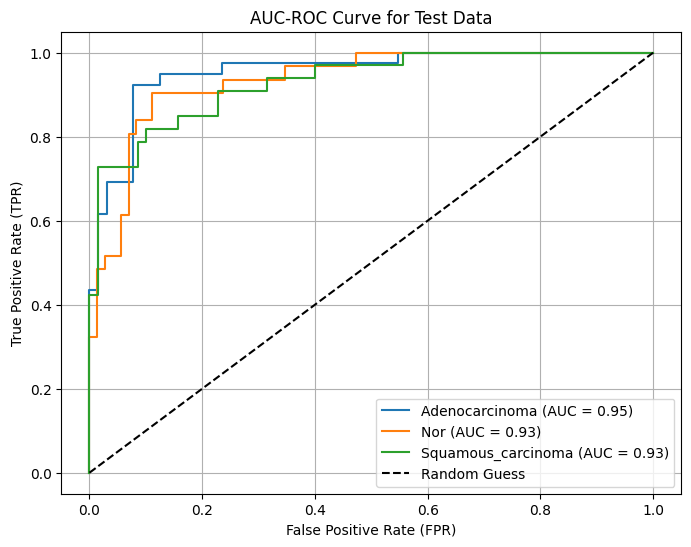


Macro-Averaged Test AUC: 0.94
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 756ms/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.88
Nor - AUC: 1.00
Squamous_carcinoma - AUC: 0.92


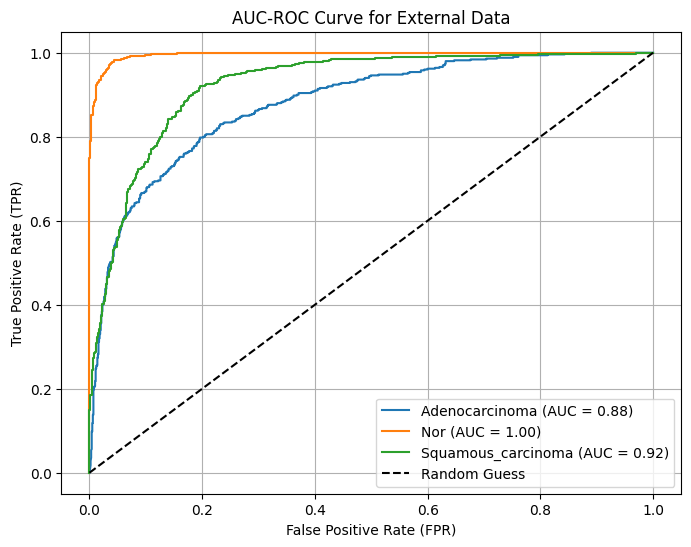


Macro-Averaged Test AUC: 0.93


In [20]:
# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

In [18]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 801ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 819ms/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.69      0.76      0.73       500
               Nor       0.97      0.91      0.94       500
Squamous_carcinoma       0.78      0.76      0.77       500

          accuracy                           0.81      1500
         macro avg       0.82      0.81      0.81      1500
      weighted avg       0.82      0.81      0.81      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.88      0.90      0.89        39
               Nor       0.75      0.87      0.81        31
Squamous_carcinoma       0.89      0.73      0.80        33

          accuracy                           0.83       103
         macro avg       0.84      0.83      0.83       103
      weighted avg       0.84      0.83      0.83       103

Validation Accuracy: 0.80

Class Labels: ['Adenocarcinoma', 'Nor', 'Squamous_carcinoma']
94/94 ━━━━━━━━━━━━━━━━━━━━ 73s 770ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 789ms/step


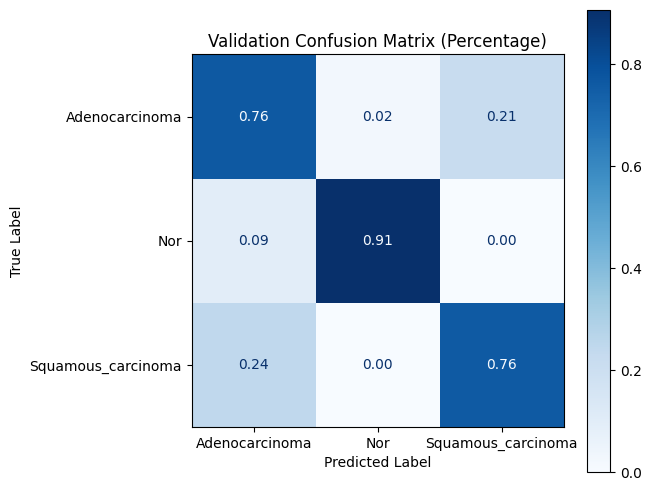

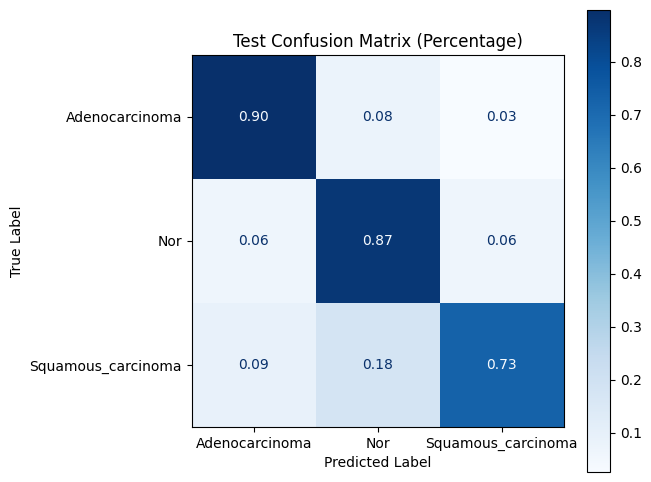

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Get Class Labels ---
class_names = list(val_generator.class_indices.keys())
print("Class Labels:", class_names)

# --- Predict on Validation and Test Sets ---
val_preds = model.predict(val_generator)
test_preds = model.predict(test_generator)

# --- Convert probabilities to class labels ---
val_pred_classes = np.argmax(val_preds, axis=1)
test_pred_classes = np.argmax(test_preds, axis=1)

# --- Get true labels ---
val_true_classes = val_generator.classes
test_true_classes = test_generator.classes

# --- Confusion Matrices ---
val_cm = confusion_matrix(val_true_classes, val_pred_classes)
test_cm = confusion_matrix(test_true_classes, test_pred_classes)

# --- Normalize Confusion Matrices to Percentages ---
val_cm_percent = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis] 
test_cm_percent = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis] 

# --- Plot Function ---
def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax, colorbar=True)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Plot Confusion Matrices ---
plot_confusion_matrix(val_cm_percent, class_names, "Validation Confusion Matrix (Percentage)")
plot_confusion_matrix(test_cm_percent, class_names, "Test Confusion Matrix (Percentage)")
